In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import shutil
import seaborn as sn
from os import listdir, walk, getcwd, mkdir
from os.path import isfile, join, sep
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# import resizing snippets
from conversion import *

In [2]:
# Create a fresh SVM subdirectory structure below
# If SVM or any of SVM subdirectory exists, then it removes the SVM subdirectory and create a new SVM folder with the structure below
# 
# +---.ipynb_checkpoints
# +---data
# |   \---Coronahack-Chest-XRay-Dataset
# |       \---Coronahack-Chest-XRay-Dataset
# |           +---SVM
# |           |   +---test_modified
# |           |   +---test_unique
# |           |   +---train_modified
# |           |   \---train_unique
# |           +---test
# |           \---train
# \---__pycache__


dir_path = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths = ["test_modified","train_modified","test_unique","train_unique"]

i = 0
loop_count = 0
while i < 4:
    loop_count += 1
    if loop_count == 7:
        break
    try:
        path = dir_path + '/SVM/' + subpaths[i]
        os.mkdir(path)
    except FileExistsError:
        # if folder exist then try remove the whole SVM subdirectory
        print("Directory " , 'SVM/' + subpaths[i] ,  " already exists")
        try:
            shutil.rmtree(dir_path + '/SVM/')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))
    except OSError:
        print ("Creation of the directory %s failed" % subpaths[i])
        path = dir_path + '/SVM/'
        os.mkdir(path)
    else:
        print ("Successfully created the directory %s " % subpaths[i])
        i += 1

Creation of the directory test_modified failed
Successfully created the directory test_modified 
Successfully created the directory train_modified 
Successfully created the directory test_unique 
Successfully created the directory train_unique 


In [3]:
# Show metadata of dataset

filename = "data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
# create dict mapping image names to labels

label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [5]:
def collect_files(path, subpaths, label = False):
    """Collate paths of files (images)
    
    Args:
        path (type = string): the folder path of the images
        subpath (type = list): subdirectories of paths
        labels (type = boolean): collate corresponding labels for images. Default to False

    Returns:
        tuple (f,l) where:
            f (type = list): List of filepaths
            l (type = list): List of corresponding labels to f
    """
    f=[]
    l=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
                if label == True:
                    l.append(label_dict[file][0])
            break
    return f,l

In [6]:
def shape_rgb_or_grey(img):
    """number of rows, columns and transform image channels to string
    
    Args:
        img (image): image
    Returns:
        list (shp[0], shp[1], color) where:
        shp[0] (type = int): number of rows
        shp[1] (type = int): number of columns 
        color (type = string): img channel type (RGB or GREY)
    """
    
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''Statistical summary of element of a list of filepath (f)
    
    Args:
        f (type = list): list of image filepaths
    Returns:
        list (df_sizes, bad_images) where:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
        bad_images (type = list): images not found in meta_df (Chest_xray_Corona_Metadata)  
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]


# visualize distribution of image sizes
def df_size_plots(df_sizes):
    
    '''Plots heat map of file height and with and a histogram of image channels
    
    Args:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
    '''
    
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
--> 1-s2.0-S0929664620300449-gr3_lrg-a.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-b.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-c.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-d.jpg is not in metadata. Skipping.
--> 191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg is not in metadata. Skipping.
--> 21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg is not in metadata. Skipping.
--> 396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg is not in metadata. Skipping.
--> 3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg is not in metadata. Skipping.
--> 5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg is not in metadata. Skipping.
--> 66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg is not in metadata. Skipping.
--> 6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg is not in metadata. Skipping.
--> 925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg is not in metadata. Skipping.
--> DE488FE1-0C44-428B-B67A-0974

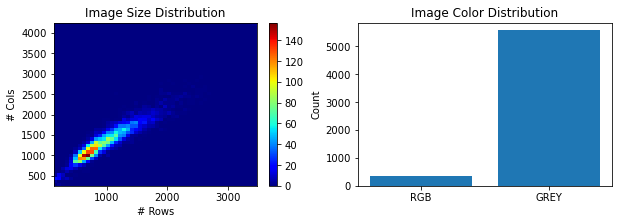

In [7]:
# Plotting the distribution of image sizes and channels in the train and test directory

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)
row_mean = df_sizes.n_rows.mean()
col_mean = df_sizes.n_cols.mean()

In [8]:
# Run conversion script on images in the train and test subdirectories.
# Save converted images to test_modified and train_modified subdirectories
# The conversion script rescales the largest dimension (width or length) of the image to 595 while preservating aspect ratio. 
# Zero pad image so resulting dimension is 600 x 600, then horizontal flip..
# Only images with metadata are converted and saved

RESIZE_BOOL = False # Originally True
ROWS = int(row_mean/2) # Does nothing since RESIZE_BOOL is False
COLS = int(col_mean/2) # Does nothing since RESIZE_BOOL is False
           
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["test","train"]
dest_subpaths = ["SVM/test_modified","SVM/train_modified"]  

for i in range(len(source_subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    # Same as Simulation #1 and set 6th input variable to True
    convert_image(test_path,test_destination_path,COLS,ROWS,RESIZE_BOOL,True,False,10,False,50,1,False,0.2,False,0.2,True,600,True,595,label_dict,print_every=200)

200 files processed out of 624 files.
400 files processed out of 624 files.
600 files processed out of 624 files.
--- There were 0 images without labels ---
200 files processed out of 5309 files.
400 files processed out of 5309 files.
600 files processed out of 5309 files.
800 files processed out of 5309 files.
1000 files processed out of 5309 files.
1200 files processed out of 5309 files.
1400 files processed out of 5309 files.
1600 files processed out of 5309 files.
1800 files processed out of 5309 files.
2000 files processed out of 5309 files.
2200 files processed out of 5309 files.
2400 files processed out of 5309 files.
2600 files processed out of 5309 files.
2800 files processed out of 5309 files.
3000 files processed out of 5309 files.
3200 files processed out of 5309 files.
3400 files processed out of 5309 files.
3600 files processed out of 5309 files.
3800 files processed out of 5309 files.
4000 files processed out of 5309 files.
4200 files processed out of 5309 files.
4400 fi

--- Parsing 5910 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed
--- There were 0 images not included in the metadata .csv ---


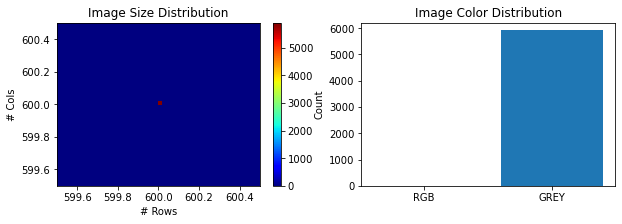

In [9]:
# Plotting the distribution of image sizes and channels for converted images.

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["SVM/test_modified","SVM/train_modified"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [10]:
# Pick one converted image per subject.
# Save the picked images in test_unique and train_unique subdirectories

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["SVM/test_modified","SVM/train_modified"]
dest_subpaths = ["SVM/test_unique","SVM/train_unique"]

for i in range(len(subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    list_unique_x_ray(test_path,test_destination_path,False,True,True)

1 files processed out of 415 files.
2 files processed out of 415 files.
3 files processed out of 415 files.
4 files processed out of 415 files.
5 files processed out of 415 files.
6 files processed out of 415 files.
7 files processed out of 415 files.
8 files processed out of 415 files.
9 files processed out of 415 files.
10 files processed out of 415 files.
11 files processed out of 415 files.
12 files processed out of 415 files.
13 files processed out of 415 files.
14 files processed out of 415 files.
15 files processed out of 415 files.
16 files processed out of 415 files.
17 files processed out of 415 files.
18 files processed out of 415 files.
19 files processed out of 415 files.
20 files processed out of 415 files.
21 files processed out of 415 files.
22 files processed out of 415 files.
23 files processed out of 415 files.
24 files processed out of 415 files.
25 files processed out of 415 files.
26 files processed out of 415 files.
27 files processed out of 415 files.
28 files p

238 files processed out of 415 files.
239 files processed out of 415 files.
240 files processed out of 415 files.
241 files processed out of 415 files.
242 files processed out of 415 files.
243 files processed out of 415 files.
244 files processed out of 415 files.
245 files processed out of 415 files.
246 files processed out of 415 files.
247 files processed out of 415 files.
248 files processed out of 415 files.
249 files processed out of 415 files.
250 files processed out of 415 files.
251 files processed out of 415 files.
252 files processed out of 415 files.
253 files processed out of 415 files.
254 files processed out of 415 files.
255 files processed out of 415 files.
256 files processed out of 415 files.
257 files processed out of 415 files.
258 files processed out of 415 files.
259 files processed out of 415 files.
260 files processed out of 415 files.
261 files processed out of 415 files.
262 files processed out of 415 files.
263 files processed out of 415 files.
264 files pr

279 files processed out of 2700 files.
280 files processed out of 2700 files.
281 files processed out of 2700 files.
282 files processed out of 2700 files.
283 files processed out of 2700 files.
284 files processed out of 2700 files.
285 files processed out of 2700 files.
286 files processed out of 2700 files.
287 files processed out of 2700 files.
288 files processed out of 2700 files.
289 files processed out of 2700 files.
290 files processed out of 2700 files.
291 files processed out of 2700 files.
292 files processed out of 2700 files.
293 files processed out of 2700 files.
294 files processed out of 2700 files.
295 files processed out of 2700 files.
296 files processed out of 2700 files.
297 files processed out of 2700 files.
298 files processed out of 2700 files.
299 files processed out of 2700 files.
300 files processed out of 2700 files.
301 files processed out of 2700 files.
302 files processed out of 2700 files.
303 files processed out of 2700 files.
304 files processed out o

523 files processed out of 2700 files.
524 files processed out of 2700 files.
525 files processed out of 2700 files.
526 files processed out of 2700 files.
527 files processed out of 2700 files.
528 files processed out of 2700 files.
529 files processed out of 2700 files.
530 files processed out of 2700 files.
531 files processed out of 2700 files.
532 files processed out of 2700 files.
533 files processed out of 2700 files.
534 files processed out of 2700 files.
535 files processed out of 2700 files.
536 files processed out of 2700 files.
537 files processed out of 2700 files.
538 files processed out of 2700 files.
539 files processed out of 2700 files.
540 files processed out of 2700 files.
541 files processed out of 2700 files.
542 files processed out of 2700 files.
543 files processed out of 2700 files.
544 files processed out of 2700 files.
545 files processed out of 2700 files.
546 files processed out of 2700 files.
547 files processed out of 2700 files.
548 files processed out o

754 files processed out of 2700 files.
755 files processed out of 2700 files.
756 files processed out of 2700 files.
757 files processed out of 2700 files.
758 files processed out of 2700 files.
759 files processed out of 2700 files.
760 files processed out of 2700 files.
761 files processed out of 2700 files.
762 files processed out of 2700 files.
763 files processed out of 2700 files.
764 files processed out of 2700 files.
765 files processed out of 2700 files.
766 files processed out of 2700 files.
767 files processed out of 2700 files.
768 files processed out of 2700 files.
769 files processed out of 2700 files.
770 files processed out of 2700 files.
771 files processed out of 2700 files.
772 files processed out of 2700 files.
773 files processed out of 2700 files.
774 files processed out of 2700 files.
775 files processed out of 2700 files.
776 files processed out of 2700 files.
777 files processed out of 2700 files.
778 files processed out of 2700 files.
779 files processed out o

995 files processed out of 2700 files.
996 files processed out of 2700 files.
997 files processed out of 2700 files.
998 files processed out of 2700 files.
999 files processed out of 2700 files.
1000 files processed out of 2700 files.
1001 files processed out of 2700 files.
1002 files processed out of 2700 files.
1003 files processed out of 2700 files.
1004 files processed out of 2700 files.
1005 files processed out of 2700 files.
1006 files processed out of 2700 files.
1007 files processed out of 2700 files.
1008 files processed out of 2700 files.
1009 files processed out of 2700 files.
1010 files processed out of 2700 files.
1011 files processed out of 2700 files.
1012 files processed out of 2700 files.
1013 files processed out of 2700 files.
1014 files processed out of 2700 files.
1015 files processed out of 2700 files.
1016 files processed out of 2700 files.
1017 files processed out of 2700 files.
1018 files processed out of 2700 files.
1019 files processed out of 2700 files.
1020 

1220 files processed out of 2700 files.
1221 files processed out of 2700 files.
1222 files processed out of 2700 files.
1223 files processed out of 2700 files.
1224 files processed out of 2700 files.
1225 files processed out of 2700 files.
1226 files processed out of 2700 files.
1227 files processed out of 2700 files.
1228 files processed out of 2700 files.
1229 files processed out of 2700 files.
1230 files processed out of 2700 files.
1231 files processed out of 2700 files.
1232 files processed out of 2700 files.
1233 files processed out of 2700 files.
1234 files processed out of 2700 files.
1235 files processed out of 2700 files.
1236 files processed out of 2700 files.
1237 files processed out of 2700 files.
1238 files processed out of 2700 files.
1239 files processed out of 2700 files.
1240 files processed out of 2700 files.
1241 files processed out of 2700 files.
1242 files processed out of 2700 files.
1243 files processed out of 2700 files.
1244 files processed out of 2700 files.


1458 files processed out of 2700 files.
1459 files processed out of 2700 files.
1460 files processed out of 2700 files.
1461 files processed out of 2700 files.
1462 files processed out of 2700 files.
1463 files processed out of 2700 files.
1464 files processed out of 2700 files.
1465 files processed out of 2700 files.
1466 files processed out of 2700 files.
1467 files processed out of 2700 files.
1468 files processed out of 2700 files.
1469 files processed out of 2700 files.
1470 files processed out of 2700 files.
1471 files processed out of 2700 files.
1472 files processed out of 2700 files.
1473 files processed out of 2700 files.
1474 files processed out of 2700 files.
1475 files processed out of 2700 files.
1476 files processed out of 2700 files.
1477 files processed out of 2700 files.
1478 files processed out of 2700 files.
1479 files processed out of 2700 files.
1480 files processed out of 2700 files.
1481 files processed out of 2700 files.
1482 files processed out of 2700 files.


1671 files processed out of 2700 files.
1672 files processed out of 2700 files.
1673 files processed out of 2700 files.
1674 files processed out of 2700 files.
1675 files processed out of 2700 files.
1676 files processed out of 2700 files.
1677 files processed out of 2700 files.
1678 files processed out of 2700 files.
1679 files processed out of 2700 files.
1680 files processed out of 2700 files.
1681 files processed out of 2700 files.
1682 files processed out of 2700 files.
1683 files processed out of 2700 files.
1684 files processed out of 2700 files.
1685 files processed out of 2700 files.
1686 files processed out of 2700 files.
1687 files processed out of 2700 files.
1688 files processed out of 2700 files.
1689 files processed out of 2700 files.
1690 files processed out of 2700 files.
1691 files processed out of 2700 files.
1692 files processed out of 2700 files.
1693 files processed out of 2700 files.
1694 files processed out of 2700 files.
1695 files processed out of 2700 files.


1893 files processed out of 2700 files.
1894 files processed out of 2700 files.
1895 files processed out of 2700 files.
1896 files processed out of 2700 files.
1897 files processed out of 2700 files.
1898 files processed out of 2700 files.
1899 files processed out of 2700 files.
1900 files processed out of 2700 files.
1901 files processed out of 2700 files.
1902 files processed out of 2700 files.
1903 files processed out of 2700 files.
1904 files processed out of 2700 files.
1905 files processed out of 2700 files.
1906 files processed out of 2700 files.
1907 files processed out of 2700 files.
1908 files processed out of 2700 files.
1909 files processed out of 2700 files.
1910 files processed out of 2700 files.
1911 files processed out of 2700 files.
1912 files processed out of 2700 files.
1913 files processed out of 2700 files.
1914 files processed out of 2700 files.
1915 files processed out of 2700 files.
1916 files processed out of 2700 files.
1917 files processed out of 2700 files.


2123 files processed out of 2700 files.
2124 files processed out of 2700 files.
2125 files processed out of 2700 files.
2126 files processed out of 2700 files.
2127 files processed out of 2700 files.
2128 files processed out of 2700 files.
2129 files processed out of 2700 files.
2130 files processed out of 2700 files.
2131 files processed out of 2700 files.
2132 files processed out of 2700 files.
2133 files processed out of 2700 files.
2134 files processed out of 2700 files.
2135 files processed out of 2700 files.
2136 files processed out of 2700 files.
2137 files processed out of 2700 files.
2138 files processed out of 2700 files.
2139 files processed out of 2700 files.
2140 files processed out of 2700 files.
2141 files processed out of 2700 files.
2142 files processed out of 2700 files.
2143 files processed out of 2700 files.
2144 files processed out of 2700 files.
2145 files processed out of 2700 files.
2146 files processed out of 2700 files.
2147 files processed out of 2700 files.


2337 files processed out of 2700 files.
2338 files processed out of 2700 files.
2339 files processed out of 2700 files.
2340 files processed out of 2700 files.
2341 files processed out of 2700 files.
2342 files processed out of 2700 files.
2343 files processed out of 2700 files.
2344 files processed out of 2700 files.
2345 files processed out of 2700 files.
2346 files processed out of 2700 files.
2347 files processed out of 2700 files.
2348 files processed out of 2700 files.
2349 files processed out of 2700 files.
2350 files processed out of 2700 files.
2351 files processed out of 2700 files.
2352 files processed out of 2700 files.
2353 files processed out of 2700 files.
2354 files processed out of 2700 files.
2355 files processed out of 2700 files.
2356 files processed out of 2700 files.
2357 files processed out of 2700 files.
2358 files processed out of 2700 files.
2359 files processed out of 2700 files.
2360 files processed out of 2700 files.
2361 files processed out of 2700 files.


2566 files processed out of 2700 files.
2567 files processed out of 2700 files.
2568 files processed out of 2700 files.
2569 files processed out of 2700 files.
2570 files processed out of 2700 files.
2571 files processed out of 2700 files.
2572 files processed out of 2700 files.
2573 files processed out of 2700 files.
2574 files processed out of 2700 files.
2575 files processed out of 2700 files.
2576 files processed out of 2700 files.
2577 files processed out of 2700 files.
2578 files processed out of 2700 files.
2579 files processed out of 2700 files.
2580 files processed out of 2700 files.
2581 files processed out of 2700 files.
2582 files processed out of 2700 files.
2583 files processed out of 2700 files.
2584 files processed out of 2700 files.
2585 files processed out of 2700 files.
2586 files processed out of 2700 files.
2587 files processed out of 2700 files.
2588 files processed out of 2700 files.
2589 files processed out of 2700 files.
2590 files processed out of 2700 files.


In [12]:
def hog_descriptor(f_paths,image = False): 
    
    '''Computes Histogram of Oriented Gradients 
    
    Args:
        f_path (type = list): list of image filepaths
        image (type = bool/list): True to capture hod image array for ALL images, list to capature only the indexes in the list
    Returns:
        tuple (hog_fd, img_dict) where:
        hog_fd (type = list): hog feature description 
        img_dict (type = list): hog image  
    '''
    
    hog_fd = []
    img_dict = {}
    i = 0
    print_every = 500
        
    for filename in f_paths:
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
    
            img = imread(filename)
            try:
                if ((image == True) or (i in image)):
                    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt=True, block_norm="L1", visualize=True)
                    hog_fd.append(fd)
                    img_dict[i]= hog_image                
                else:
                    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2),  transform_sqrt= True, block_norm="L1")
                    hog_fd.append(fd)

                
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except:
                print("Unknown exception occurred.") 
            
        else:
            print("Skipping {}.".format(filename))
            
    return(hog_fd, img_dict)

In [13]:
subpaths = ["SVM/train_unique"]

f_train,label_train = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in training set
hog_train, img_train = hog_descriptor(f_train,[1,2,3]) 

-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed


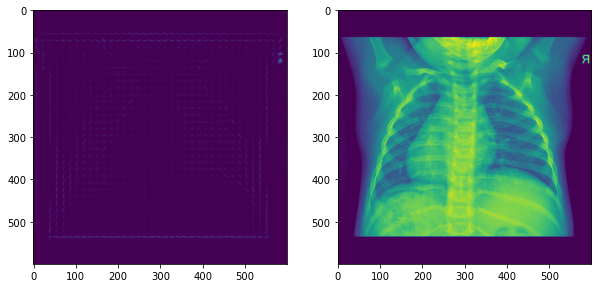

In [15]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_train = imread(f_train[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_train[2]/img_train[2].max()) 
ax[1].imshow(ex_img_train)

In [16]:
subpaths = ["SVM/test_unique"]

f_test, label_test = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in test set
hog_test, img_test = hog_descriptor(f_test, [2,3])

-> 0 images parsed


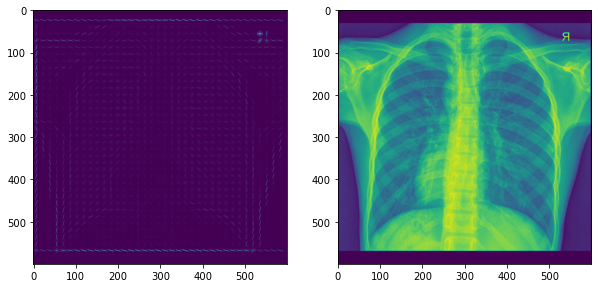

In [18]:
# Plot  hog image on the left and corresponding x-ray on the right

ex_img_test = imread(f_test[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_test[2]/img_test[2].max()) 
ax[1].imshow(ex_img_test)

In [19]:
def data_stack(hog_fd,label):
    ''' Creates  array of hog descriptors and a flattened array of their corresponding labels

    Args:
        hog_fd (type = list): list of hog feature description 
        label (list): list of labels of hog_fd
    Returns:
        tuple (X, y) where:
        X (type = array): stacked hog feature description in hog_fd  
        y (type = array): flattened array of labels of hog_fd 
    '''
    label =  np.array(label).reshape(len(label),1)
    hog_fd = np.array(hog_fd)

    x,y = hog_fd,label.ravel()
    return (x,y)

In [20]:
# Preprocessed training and test set

x_train,y_train = data_stack(hog_train,label_train)
x_test,y_test = data_stack(hog_test,label_test)

In [22]:
# Standardize data
# fit support vector classifier with the polynomial kernel and hyper-parameters C=1, and gamma=0.1.

model = make_pipeline(StandardScaler(), SVC(C=1, gamma=0.1, kernel='poly',probability = True,random_state = 7))
model.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma=0.1, kernel='poly', probability=True,
                     random_state=7))])

In [23]:
# Perform prediction using the preprocessed test set

predictions_probs = model.predict_proba(x_test)
predictions = model.predict(x_test)

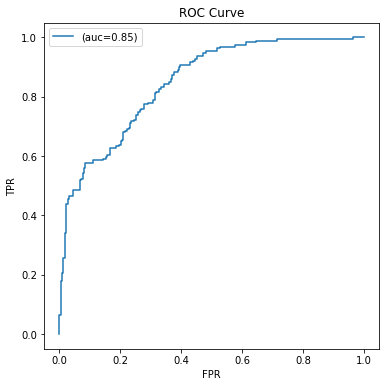

In [24]:
# Plot ROC curve

fpr, tpr,_ = metrics.roc_curve(y_test,predictions_probs[:,1] ,pos_label='Pnemonia')
auc = metrics.roc_auc_score(y_test,predictions_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label='(auc={:3.2f})'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()

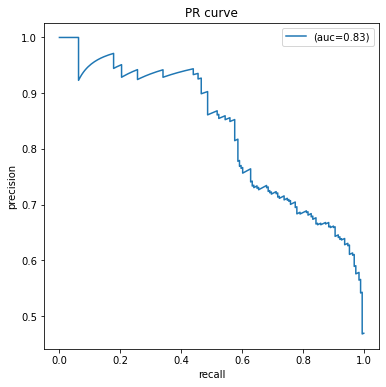

In [25]:
# Plot PR curve

prec, rec, threshs = metrics.precision_recall_curve(y_test,predictions_probs[:,1],pos_label='Pnemonia')
auc = metrics.auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec,prec,label='(auc={:3.2f})'.format(auc))
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("PR curve")
plt.legend()

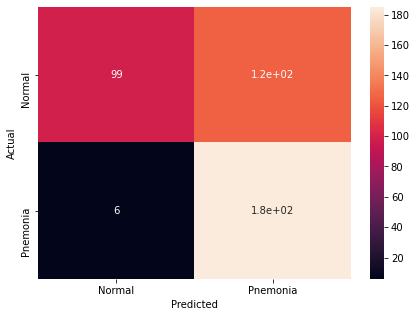

In [26]:
# Plot confusion matrix

data = {"y_test": y_test, "y_hat":predictions}
df = pd.DataFrame(data, columns=["y_test", "y_hat"])
confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
f, ax = plt.subplots(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True)
plt.show()